##Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Concatenate, Attention, Dense, Input
from keras.utils import plot_model
from tqdm import tqdm

# Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_data = pd.read_json("/content/drive/MyDrive/Meitei_Mayek/mni_train.json", lines = True)
test_data = pd.read_json("/content/drive/MyDrive/Meitei_Mayek/mni_test.json", lines = True)
valid_data = pd.read_json("/content/drive/MyDrive/Meitei_Mayek/mni_valid.json", lines = True)
train_data,test_data,valid_data

(      unique_identifier  native word      english word     source     score
 0                  mni1         ꯂꯨꯗꯨ              ludu    AK-Freq       NaN
 1                  mni2        ꯑꯣꯛꯁꯥ             oksha    AK-Freq       NaN
 2                  mni3        ꯊꯝꯕꯥꯜ           thambal    AK-Freq       NaN
 3                  mni4  ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ  lengtheinabasidi    AK-Freq       NaN
 4                  mni5     ꯑꯦꯄ꯭ꯂꯥꯢꯗ           applied    AK-Freq       NaN
 ...                 ...          ...               ...        ...       ...
 10055          mni10056        ꯄꯥꯡꯒꯂ          panggala  IndicCorp -0.174713
 10056          mni10057    ꯈꯣꯔꯤꯔꯣꯂꯒꯤ       khorirolagi  IndicCorp -0.160257
 10057          mni10058       ꯃꯁꯤꯡꯈꯥ        masingkhaa  IndicCorp -0.089934
 10058          mni10059        ꯄꯣꯛꯄꯥ            pokpaa  IndicCorp -0.174966
 10059          mni10060     ꯁꯅꯥꯖꯥꯎꯕꯅ       sanajaobana  IndicCorp -0.303592
 
 [10060 rows x 5 columns],
      unique_identifier   native word  english 

In [ ]:
train = train_data[["native word","english word"]].copy()
test = test_data[["native word", "english word"]].copy()
valid = valid_data[["native word", "english word"]].copy()
train, test, valid

(       native word      english word
 0             ꯂꯨꯗꯨ              ludu
 1            ꯑꯣꯛꯁꯥ             oksha
 2            ꯊꯝꯕꯥꯜ           thambal
 3      ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ  lengtheinabasidi
 4         ꯑꯦꯄ꯭ꯂꯥꯢꯗ           applied
 ...            ...               ...
 10055        ꯄꯥꯡꯒꯂ          panggala
 10056    ꯈꯣꯔꯤꯔꯣꯂꯒꯤ       khorirolagi
 10057       ꯃꯁꯤꯡꯈꯥ        masingkhaa
 10058        ꯄꯣꯛꯄꯥ            pokpaa
 10059     ꯁꯅꯥꯖꯥꯎꯕꯅ       sanajaobana
 
 [10060 rows x 2 columns],
        native word  english word
 0            ꯌꯥꯜꯂꯒ       yallaga
 1          ꯁꯔꯨꯛꯁꯤꯡ    sharuksing
 2              ꯁꯛꯄ         sakpa
 3            ꯑꯁꯤꯅꯤ         asini
 4            ꯖꯦꯕꯤꯅ        jebina
 ...            ...           ...
 4884  ꯏꯟꯁꯦꯛꯇꯤꯁꯥꯢꯗꯁ  insecticides
 4885         ꯔꯥꯖꯦꯁ        rajesh
 4886         ꯈꯇ꯭ꯔꯤ        khatri
 4887        ꯖꯣꯍꯥꯔꯤ        johari
 4888        ꯖꯨꯅꯥꯒꯔ      junagadh
 
 [4889 rows x 2 columns],
      native word english word
 0           ꯁꯦꯝꯏ         semi
 1      ꯂꯥꯢꯅꯤꯡꯒꯤꯅ

#Preprocessing

In [ ]:
def add_start_and_end(text):
  text = "\t" + text + "\n"
  return text

In [ ]:
train["decoder input"] = train["native word"].apply(add_start_and_end)
train

,native word,english word,decoder input
0,ꯂꯨꯗꯨ,ludu,\tꯂꯨꯗꯨ\n
1,ꯑꯣꯛꯁꯥ,oksha,\tꯑꯣꯛꯁꯥ\n
2,ꯊꯝꯕꯥꯜ,thambal,\tꯊꯝꯕꯥꯜ\n
3,ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ,lengtheinabasidi,\tꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ\n
4,ꯑꯦꯄ꯭ꯂꯥꯢꯗ,applied,\tꯑꯦꯄ꯭ꯂꯥꯢꯗ\n
...,...,...,...
10055,ꯄꯥꯡꯒꯂ,panggala,\tꯄꯥꯡꯒꯂ\n
10056,ꯈꯣꯔꯤꯔꯣꯂꯒꯤ,khorirolagi,\tꯈꯣꯔꯤꯔꯣꯂꯒꯤ\n
10057,ꯃꯁꯤꯡꯈꯥ,masingkhaa,\tꯃꯁꯤꯡꯈꯥ\n
10058,ꯄꯣꯛꯄꯥ,pokpaa,\tꯄꯣꯛꯄꯥ\n


In [ ]:
def add_end(text):
  text = text + "\n"
  return text

In [ ]:
train['decoder output'] = train['native word'].apply(add_end)
train

,native word,english word,decoder input,decoder output
0,ꯂꯨꯗꯨ,ludu,\tꯂꯨꯗꯨ\n,ꯂꯨꯗꯨ\n
1,ꯑꯣꯛꯁꯥ,oksha,\tꯑꯣꯛꯁꯥ\n,ꯑꯣꯛꯁꯥ\n
2,ꯊꯝꯕꯥꯜ,thambal,\tꯊꯝꯕꯥꯜ\n,ꯊꯝꯕꯥꯜ\n
3,ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ,lengtheinabasidi,\tꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ\n,ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ\n
4,ꯑꯦꯄ꯭ꯂꯥꯢꯗ,applied,\tꯑꯦꯄ꯭ꯂꯥꯢꯗ\n,ꯑꯦꯄ꯭ꯂꯥꯢꯗ\n
...,...,...,...,...
10055,ꯄꯥꯡꯒꯂ,panggala,\tꯄꯥꯡꯒꯂ\n,ꯄꯥꯡꯒꯂ\n
10056,ꯈꯣꯔꯤꯔꯣꯂꯒꯤ,khorirolagi,\tꯈꯣꯔꯤꯔꯣꯂꯒꯤ\n,ꯈꯣꯔꯤꯔꯣꯂꯒꯤ\n
10057,ꯃꯁꯤꯡꯈꯥ,masingkhaa,\tꯃꯁꯤꯡꯈꯥ\n,ꯃꯁꯤꯡꯈꯥ\n
10058,ꯄꯣꯛꯄꯥ,pokpaa,\tꯄꯣꯛꯄꯥ\n,ꯄꯣꯛꯄꯥ\n


## Tokenization

### English

In [ ]:
eng_words = train['english word']
eng_words

0                    ludu
1                   oksha
2                 thambal
3        lengtheinabasidi
4                 applied
               ...       
10055            panggala
10056         khorirolagi
10057          masingkhaa
10058              pokpaa
10059         sanajaobana
Name: english word, Length: 10060, dtype: object

In [ ]:
eng_tokenizer = Tokenizer(filters = '', char_level = True)
eng_tokenizer.fit_on_texts(eng_words)
eng_tokens = eng_tokenizer.word_index
print("Number of english tokens: ", len(eng_tokens))
print(eng_tokens)

Number of english tokens:  26
{'a': 1, 'i': 2, 'n': 3, 'h': 4, 'g': 5, 'k': 6, 'm': 7, 't': 8, 'o': 9, 'u': 10, 'e': 11, 'l': 12, 's': 13, 'p': 14, 'b': 15, 'r': 16, 'd': 17, 'c': 18, 'y': 19, 'w': 20, 'j': 21, 'f': 22, 'v': 23, 'z': 24, 'q': 25, 'x': 26}


### Meitei Mayek

In [ ]:
mm_words = train['decoder input']
mm_words

0               \tꯂꯨꯗꯨ\n
1              \tꯑꯣꯛꯁꯥ\n
2              \tꯊꯝꯕꯥꯜ\n
3        \tꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ\n
4           \tꯑꯦꯄ꯭ꯂꯥꯢꯗ\n
              ...       
10055          \tꯄꯥꯡꯒꯂ\n
10056      \tꯈꯣꯔꯤꯔꯣꯂꯒꯤ\n
10057         \tꯃꯁꯤꯡꯈꯥ\n
10058          \tꯄꯣꯛꯄꯥ\n
10059       \tꯁꯅꯥꯖꯥꯎꯕꯅ\n
Name: decoder input, Length: 10060, dtype: object

In [ ]:
label = train["decoder output"]
label

0               ꯂꯨꯗꯨ\n
1              ꯑꯣꯛꯁꯥ\n
2              ꯊꯝꯕꯥꯜ\n
3        ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ\n
4           ꯑꯦꯄ꯭ꯂꯥꯢꯗ\n
             ...      
10055          ꯄꯥꯡꯒꯂ\n
10056      ꯈꯣꯔꯤꯔꯣꯂꯒꯤ\n
10057         ꯃꯁꯤꯡꯈꯥ\n
10058          ꯄꯣꯛꯄꯥ\n
10059       ꯁꯅꯥꯖꯥꯎꯕꯅ\n
Name: decoder output, Length: 10060, dtype: object

In [ ]:
mm_tokenizer = Tokenizer(filters = '', char_level = True)
mm_tokenizer.fit_on_texts(mm_words)
mm_tokens = mm_tokenizer.word_index
print("Number of Meitei Mayek tokens: ", len(mm_tokens))
print(mm_tokens)

Number of Meitei Mayek tokens:  46
{'\t': 1, '\n': 2, 'ꯤ': 3, 'ꯥ': 4, 'ꯅ': 5, 'ꯁ': 6, 'ꯕ': 7, 'ꯨ': 8, 'ꯔ': 9, 'ꯣ': 10, 'ꯂ': 11, 'ꯡ': 12, 'ꯗ': 13, 'ꯟ': 14, 'ꯃ': 15, 'ꯄ': 16, 'ꯒ': 17, 'ꯦ': 18, 'ꯝ': 19, 'ꯇ': 20, 'ꯛ': 21, 'ꯀ': 22, 'ꯈ': 23, 'ꯌ': 24, 'ꯊ': 25, 'ꯍ': 26, 'ꯆ': 27, 'ꯩ': 28, 'ꯑ': 29, 'ꯐ': 30, 'ꯠ': 31, 'ꯜ': 32, 'ꯢ': 33, 'ꯧ': 34, 'ꯏ': 35, 'ꯖ': 36, 'ꯋ': 37, '꯭': 38, 'ꯉ': 39, 'ꯎ': 40, 'ꯪ': 41, 'ꯞ': 42, 'ꯚ': 43, 'ꯓ': 44, 'ꯙ': 45, 'ꯘ': 46}


## Preparing encoder input and output

In [ ]:
eng_vocab_size = len(eng_tokens) + 1
mm_vocab_size = len(mm_tokens) + 1

### English

In [ ]:
eng_seq = eng_tokenizer.texts_to_sequences(eng_words)
eng_seq[12], eng_words[12]

([11, 7, 2, 16, 1, 8, 11], 'emirate')

In [ ]:
max_encoder_length = eng_words.str.len().max()
max_encoder_length

22

In [ ]:
eng_padded = pad_sequences(eng_seq, maxlen = max_encoder_length, padding = 'post')

In [ ]:
for i in range(10):
  print(str(eng_words[i]) + " " + str(eng_seq[i]) + str(eng_padded[i]))

ludu [12, 10, 17, 10][12 10 17 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
oksha [9, 6, 13, 4, 1][ 9  6 13  4  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
thambal [8, 4, 1, 7, 15, 1, 12][ 8  4  1  7 15  1 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
lengtheinabasidi [12, 11, 3, 5, 8, 4, 11, 2, 3, 1, 15, 1, 13, 2, 17, 2][12 11  3  5  8  4 11  2  3  1 15  1 13  2 17  2  0  0  0  0  0  0]
applied [1, 14, 14, 12, 2, 11, 17][ 1 14 14 12  2 11 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
humaang [4, 10, 7, 1, 1, 3, 5][ 4 10  7  1  1  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
jesusna [21, 11, 13, 10, 13, 3, 1][21 11 13 10 13  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
nungsijaba [3, 10, 3, 5, 13, 2, 21, 1, 15, 1][ 3 10  3  5 13  2 21  1 15  1  0  0  0  0  0  0  0  0  0  0  0  0]
leihalli [12, 11, 2, 4, 1, 12, 12, 2][12 11  2  4  1 12 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
satli [13, 1, 8, 12, 2][13  1  8 12  2  0  0  0  0  0  0  0  0 

In [ ]:
for i in range(10):
  for character in eng_words[i]:
    number = eng_tokens[character]
    print(str(character) + "-" + str(number))
  for list in eng_seq[i]:
    print(list, end = " ")
  print("\n")

l-12
u-10
d-17
u-10
12 10 17 10 

o-9
k-6
s-13
h-4
a-1
9 6 13 4 1 

t-8
h-4
a-1
m-7
b-15
a-1
l-12
8 4 1 7 15 1 12 

l-12
e-11
n-3
g-5
t-8
h-4
e-11
i-2
n-3
a-1
b-15
a-1
s-13
i-2
d-17
i-2
12 11 3 5 8 4 11 2 3 1 15 1 13 2 17 2 

a-1
p-14
p-14
l-12
i-2
e-11
d-17
1 14 14 12 2 11 17 

h-4
u-10
m-7
a-1
a-1
n-3
g-5
4 10 7 1 1 3 5 

j-21
e-11
s-13
u-10
s-13
n-3
a-1
21 11 13 10 13 3 1 

n-3
u-10
n-3
g-5
s-13
i-2
j-21
a-1
b-15
a-1
3 10 3 5 13 2 21 1 15 1 

l-12
e-11
i-2
h-4
a-1
l-12
l-12
i-2
12 11 2 4 1 12 12 2 

s-13
a-1
t-8
l-12
i-2
13 1 8 12 2 



In [ ]:
input = eng_padded

###Meitei Mayek

In [ ]:
decoder_input_seq = mm_tokenizer.texts_to_sequences(mm_words)
decoder_output_seq = mm_tokenizer.texts_to_sequences(label)
decoder_input_seq[0], decoder_output_seq[0], mm_words[0]

([1, 11, 8, 13, 8, 2], [11, 8, 13, 8, 2], '\tꯂꯨꯗꯨ\n')

In [ ]:
max_decoder_length = mm_words.str.len().max()
max_decoder_length

20

In [ ]:
decoder_input_padded = pad_sequences(decoder_input_seq, maxlen = max_decoder_length, padding = 'post')

In [ ]:
for i in range(10):
  print(str(mm_words[i]) + str(decoder_input_seq[i]) + str(decoder_input_padded[i]))

	ꯂꯨꯗꯨ
[1, 11, 8, 13, 8, 2][ 1 11  8 13  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯑꯣꯛꯁꯥ
[1, 29, 10, 21, 6, 4, 2][ 1 29 10 21  6  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯊꯝꯕꯥꯜ
[1, 25, 19, 7, 4, 32, 2][ 1 25 19  7  4 32  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ
[1, 11, 18, 12, 25, 28, 5, 7, 6, 3, 13, 3, 2][ 1 11 18 12 25 28  5  7  6  3 13  3  2  0  0  0  0  0  0  0]
	ꯑꯦꯄ꯭ꯂꯥꯢꯗ
[1, 29, 18, 16, 38, 11, 4, 33, 13, 2][ 1 29 18 16 38 11  4 33 13  2  0  0  0  0  0  0  0  0  0  0]
	ꯍꯨꯃꯥꯡ
[1, 26, 8, 15, 4, 12, 2][ 1 26  8 15  4 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯖꯤꯖꯁꯅ
[1, 36, 3, 36, 6, 5, 2][ 1 36  3 36  6  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯅꯨꯡꯁꯤꯖꯕ
[1, 5, 8, 12, 6, 3, 36, 7, 2][ 1  5  8 12  6  3 36  7  2  0  0  0  0  0  0  0  0  0  0  0]
	ꯂꯩꯍꯜꯂꯤ
[1, 11, 28, 26, 32, 11, 3, 2][ 1 11 28 26 32 11  3  2  0  0  0  0  0  0  0  0  0  0  0  0]
	ꯁꯥꯠꯂꯤ
[1, 6, 4, 31, 11, 3, 2][ 1  6  4 31 11  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
decoder_output_padded = pad_sequences(decoder_output_seq, maxlen = max_decoder_length, padding = 'post')

In [ ]:
for i in range(10):
  print(str(label[i]) + str(decoder_output_seq[i]) + str(decoder_output_padded[i]))

ꯂꯨꯗꯨ
[11, 8, 13, 8, 2][11  8 13  8  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯑꯣꯛꯁꯥ
[29, 10, 21, 6, 4, 2][29 10 21  6  4  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯊꯝꯕꯥꯜ
[25, 19, 7, 4, 32, 2][25 19  7  4 32  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯂꯦꯡꯊꯩꯅꯕꯁꯤꯗꯤ
[11, 18, 12, 25, 28, 5, 7, 6, 3, 13, 3, 2][11 18 12 25 28  5  7  6  3 13  3  2  0  0  0  0  0  0  0  0]
ꯑꯦꯄ꯭ꯂꯥꯢꯗ
[29, 18, 16, 38, 11, 4, 33, 13, 2][29 18 16 38 11  4 33 13  2  0  0  0  0  0  0  0  0  0  0  0]
ꯍꯨꯃꯥꯡ
[26, 8, 15, 4, 12, 2][26  8 15  4 12  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯖꯤꯖꯁꯅ
[36, 3, 36, 6, 5, 2][36  3 36  6  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯅꯨꯡꯁꯤꯖꯕ
[5, 8, 12, 6, 3, 36, 7, 2][ 5  8 12  6  3 36  7  2  0  0  0  0  0  0  0  0  0  0  0  0]
ꯂꯩꯍꯜꯂꯤ
[11, 28, 26, 32, 11, 3, 2][11 28 26 32 11  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
ꯁꯥꯠꯂꯤ
[6, 4, 31, 11, 3, 2][ 6  4 31 11  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [ ]:
for i in range(10):
  for character in mm_words[i]:
    number = mm_tokens[character]
    print(str(character) + "-" + str(number))
  for list in decoder_input_seq[i]:
    print(list, end = " ")
  print("\n")

	-1
ꯂ-11
ꯨ-8
ꯗ-13
ꯨ-8

-2
1 11 8 13 8 2 

	-1
ꯑ-29
ꯣ-10
ꯛ-21
ꯁ-6
ꯥ-4

-2
1 29 10 21 6 4 2 

	-1
ꯊ-25
ꯝ-19
ꯕ-7
ꯥ-4
ꯜ-32

-2
1 25 19 7 4 32 2 

	-1
ꯂ-11
ꯦ-18
ꯡ-12
ꯊ-25
ꯩ-28
ꯅ-5
ꯕ-7
ꯁ-6
ꯤ-3
ꯗ-13
ꯤ-3

-2
1 11 18 12 25 28 5 7 6 3 13 3 2 

	-1
ꯑ-29
ꯦ-18
ꯄ-16
꯭-38
ꯂ-11
ꯥ-4
ꯢ-33
ꯗ-13

-2
1 29 18 16 38 11 4 33 13 2 

	-1
ꯍ-26
ꯨ-8
ꯃ-15
ꯥ-4
ꯡ-12

-2
1 26 8 15 4 12 2 

	-1
ꯖ-36
ꯤ-3
ꯖ-36
ꯁ-6
ꯅ-5

-2
1 36 3 36 6 5 2 

	-1
ꯅ-5
ꯨ-8
ꯡ-12
ꯁ-6
ꯤ-3
ꯖ-36
ꯕ-7

-2
1 5 8 12 6 3 36 7 2 

	-1
ꯂ-11
ꯩ-28
ꯍ-26
ꯜ-32
ꯂ-11
ꯤ-3

-2
1 11 28 26 32 11 3 2 

	-1
ꯁ-6
ꯥ-4
ꯠ-31
ꯂ-11
ꯤ-3

-2
1 6 4 31 11 3 2 



In [ ]:
decoder_input = decoder_input_padded
decoder_output = decoder_output_padded

# Model Architecture - BiLSTM with attention

In [ ]:
latent_dim = 64
emb_dim = 100

### Encoder

In [ ]:
input.shape

(10060, 22)

In [ ]:
encoder_input = keras.Input(shape = (max_encoder_length,), name = "encoder_input")
encoder_input

<KerasTensor: shape=(None, 22) dtype=float32 (created by layer 'encoder_input')>

In [ ]:
eng_vocab_size

27

In [ ]:
encoder_emb = Embedding(input_dim = eng_vocab_size, output_dim = emb_dim, mask_zero = True, name = "encoder_embedding")(encoder_input)
encoder_emb

<KerasTensor: shape=(None, 22, 100) dtype=float32 (created by layer 'encoder_embedding')>

In [ ]:
encoder_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(units = latent_dim, return_state = True, return_sequences = True), name = "bilstm") (encoder_emb)

In [ ]:
encoder_outputs.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape

(TensorShape([None, 22, 128]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]))

In [ ]:
encoder_h = Concatenate(axis = -1, name = "concat_h")([forward_h, backward_h])
encoder_c = Concatenate(axis = -1, name = "concat_c")([forward_c, backward_c])
encoder_h.shape, encoder_c.shape


(TensorShape([None, 128]), TensorShape([None, 128]))

In [ ]:
encoder_states = [encoder_h, encoder_c]
encoder_states

[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'concat_h')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'concat_c')>]

## Decoder

In [ ]:
decoder_input = keras.Input(shape = (max_decoder_length,), name = "decoder_input")
decoder_input

<KerasTensor: shape=(None, 20) dtype=float32 (created by layer 'decoder_input')>

In [ ]:
decoder_emb = Embedding(input_dim = mm_vocab_size, output_dim = emb_dim, mask_zero = True, name = "decoder_embedding")(decoder_input)
decoder_emb

<KerasTensor: shape=(None, 20, 100) dtype=float32 (created by layer 'decoder_embedding')>

In [ ]:
decoder_output, decoder_h, decoder_c = LSTM(units = encoder_h.shape[1], return_sequences = True, return_state = True, name = "decoder_lstm")(decoder_emb, initial_state = encoder_states)


In [ ]:
decoder_output.shape, decoder_h.shape, decoder_c.shape

(TensorShape([None, 20, 128]),
 TensorShape([None, 128]),
 TensorShape([None, 128]))

### Attention

In [ ]:
attention = Attention()

In [ ]:
context_vector = attention(inputs = [decoder_output, encoder_outputs])

In [ ]:
context_vector

<KerasTensor: shape=(None, 20, 128) dtype=float32 (created by layer 'attention')>

In [ ]:
concatenated_outputs = Concatenate(axis = -1)([context_vector, decoder_output])

In [ ]:
concatenated_outputs.shape

TensorShape([None, 20, 256])

In [ ]:
decoder_dense = Dense(mm_vocab_size, name = "decoder_dense", activation = "softmax")
decoder_output = decoder_dense(concatenated_outputs)
decoder_output

<KerasTensor: shape=(None, 20, 47) dtype=float32 (created by layer 'decoder_dense')>

## Building Model

In [ ]:
model = keras.Model(inputs = [encoder_input, decoder_input], outputs = decoder_output)

In [ ]:
model = keras.Model([encoder_input, decoder_input], decoder_output)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 22)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 22, 100)              2700      ['encoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_input (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 bilstm (Bidirectional)      [(None, 22, 128),            84480     ['encoder_embedding[0][0

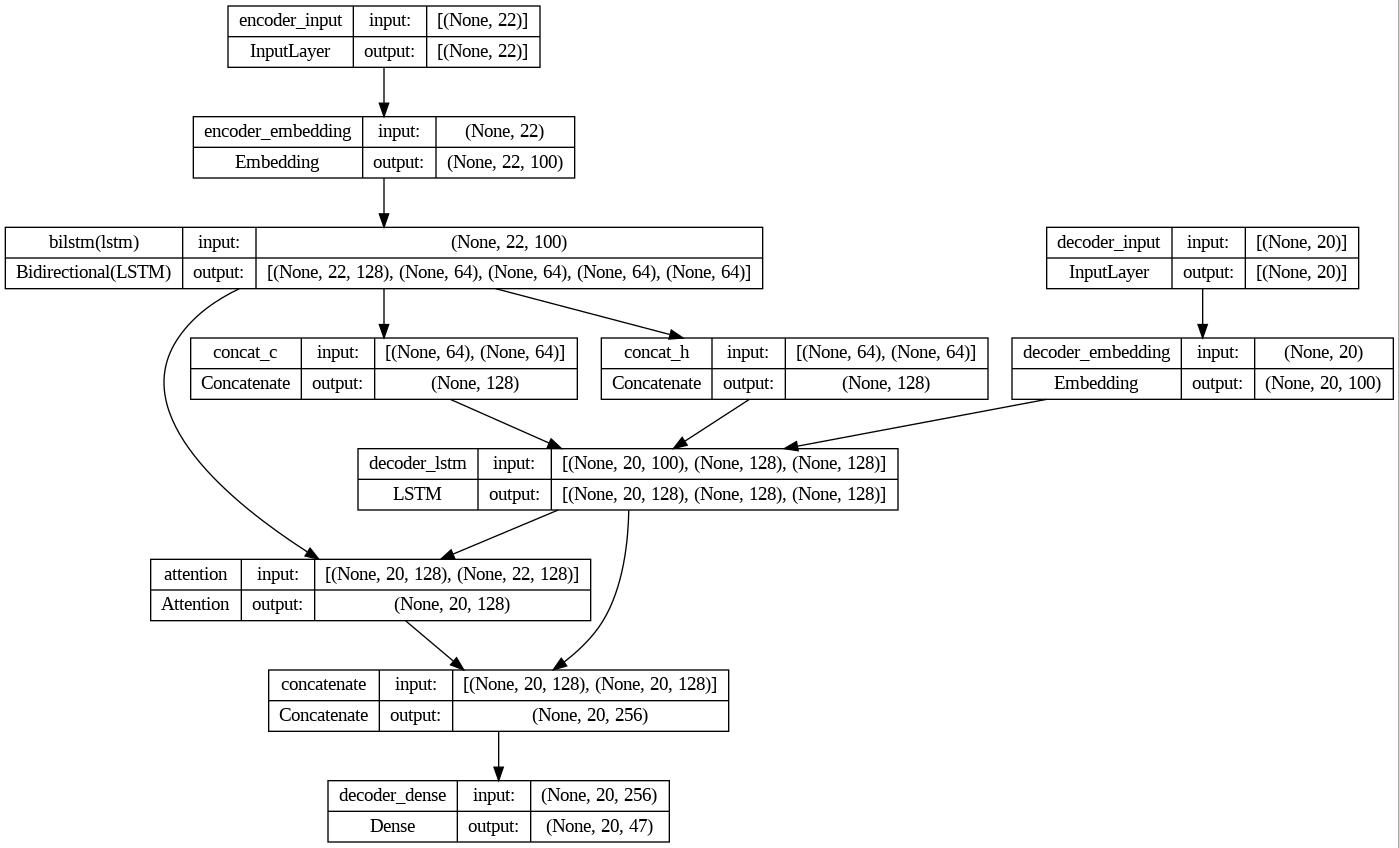

In [ ]:
plot_model(model, show_shapes = True, to_file = "model.jpg")

# Training Model

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)


In [ ]:
batch_size = 30
epochs = 500


history = model.fit(
    [eng_padded, decoder_input_padded],
    decoder_output_padded,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[es]
)

model.save("/content/drive/MyDrive/Meitei_Mayek/final_mm_eng_bi_attention.h5")

Epoch 1/500
269/269 [==============================] - 8s 29ms/step - loss: 0.0840 - accuracy: 0.9739 - val_loss: 0.1872 - val_accuracy: 0.9459
Epoch 2/500
269/269 [==============================] - 7s 27ms/step - loss: 0.0909 - accuracy: 0.9725 - val_loss: 0.1745 - val_accuracy: 0.9466
Epoch 3/500
269/269 [==============================] - 7s 24ms/step - loss: 0.0805 - accuracy: 0.9756 - val_loss: 0.1836 - val_accuracy: 0.9438
Epoch 4/500
269/269 [==============================] - 6s 23ms/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 0.1819 - val_accuracy: 0.9469
Epoch 5/500
269/269 [==============================] - 5s 19ms/step - loss: 0.0708 - accuracy: 0.9773 - val_loss: 0.1771 - val_accuracy: 0.9469
Epoch 6/500
269/269 [==============================] - 8s 29ms/step - loss: 0.0698 - accuracy: 0.9781 - val_loss: 0.1937 - val_accuracy: 0.9457
Epoch 7/500
269/269 [==============================] - 6s 23ms/step - loss: 0.0660 - accuracy: 0.9795 - val_loss: 0.1720 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


###Loading model

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Meitei_Mayek/final_mm_eng_bi_attention.h5")
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 22)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 22, 100)              2700      ['encoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 decoder_input (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 bilstm (Bidirectional)      [(None, 22, 128),            84480     ['encoder_embedding[0][0

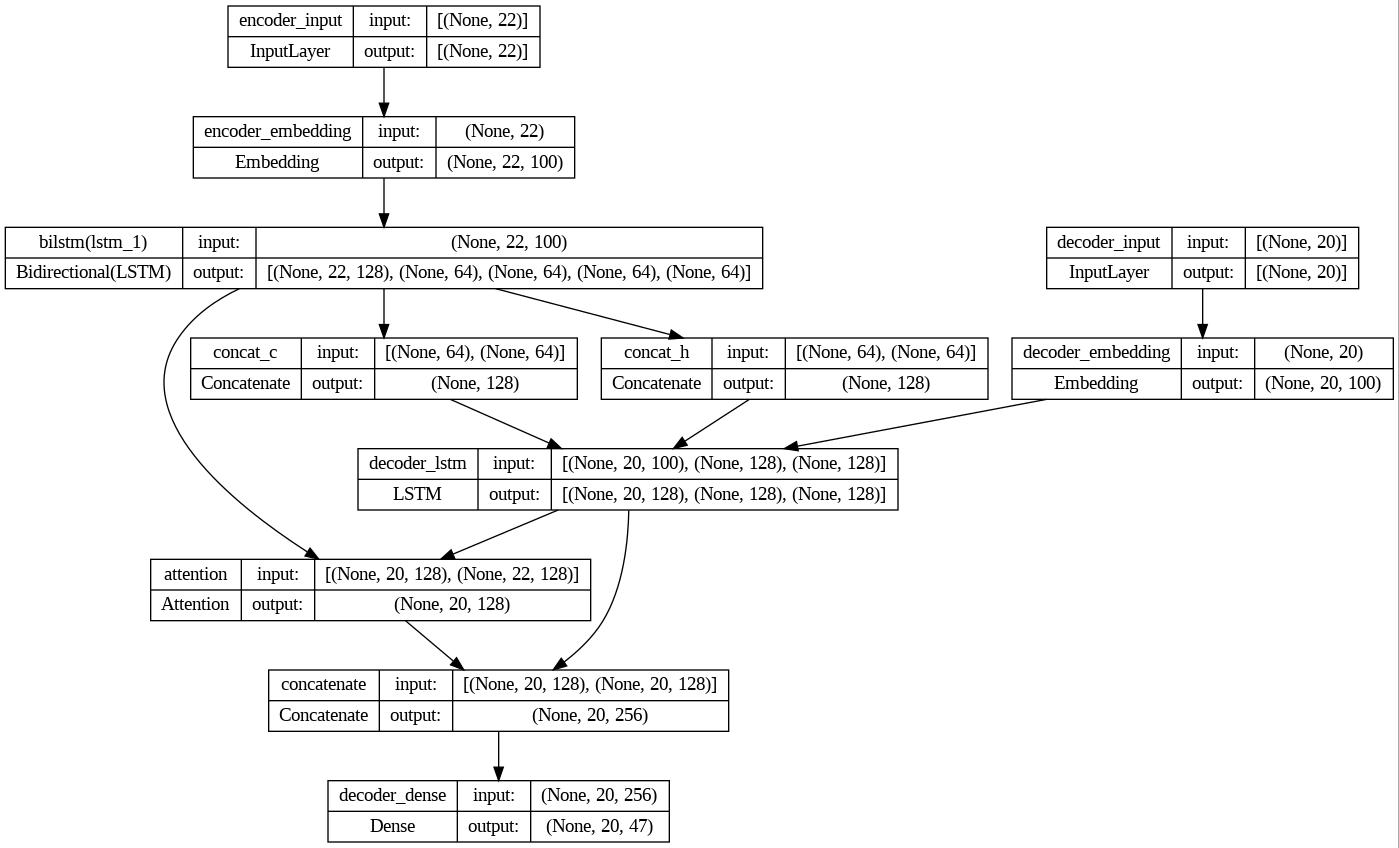

In [ ]:
plot_model(model, show_shapes = True, to_file = "model.jpg")

#Inference

In [ ]:
inputs = model.get_layer('encoder_input').output
bi_lstm_output, f_h, f_c, b_h, b_c = model.get_layer('bilstm').output


In [ ]:
inputs.shape, bi_lstm_output.shape, f_h.shape, f_c.shape, b_h.shape, b_c.shape

(TensorShape([None, 22]),
 TensorShape([None, 22, 128]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]),
 TensorShape([None, 64]))

In [ ]:
concat_h = model.get_layer('concat_h').output
concat_c = model.get_layer('concat_c').output
concat_h.shape, concat_c.shape

(TensorShape([None, 128]), TensorShape([None, 128]))

### Encoder

In [ ]:
encoder = keras.Model(inputs = inputs, outputs = [bi_lstm_output, concat_h, concat_c])
encoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 22)]                 0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 22, 100)              2700      ['encoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 bilstm (Bidirectional)      [(None, 22, 128),            84480     ['encoder_embedding[0][0]']   
                              (None, 64),                                                         
                              (None, 64),                                                   

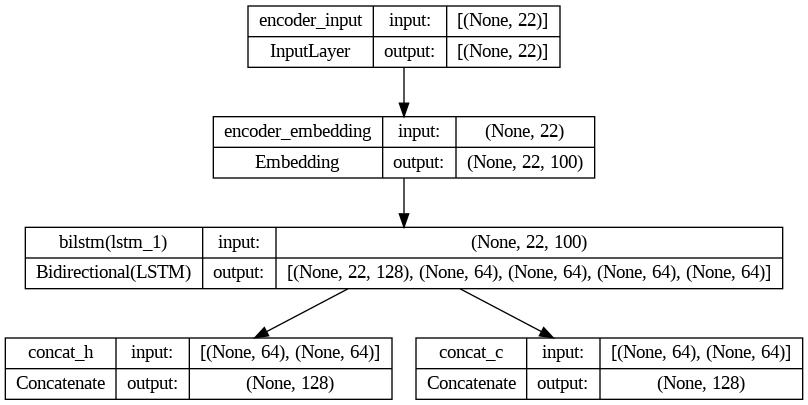

In [ ]:
plot_model(encoder, show_shapes = True, to_file = 'encoder.jpg')

### Decoder

In [ ]:
decoder_input_encoder_seq = Input(shape = (22, 128))
decoder_input_h1 = Input(shape = (128,))
decoder_input_c1 = Input(shape = (128,))

In [ ]:
decoder_inputs = model.get_layer('decoder_input').output
embedding_layer = model.get_layer('decoder_embedding')
decoder_lstm = model.get_layer('decoder_lstm')
attention = model.get_layer('attention')

In [ ]:
decoder_embed = embedding_layer(decoder_inputs)
decoder_embed.shape

TensorShape([None, 20, 100])

In [ ]:
decoder_lstm_out, decoder_out_h, decoder_out_c = decoder_lstm(decoder_embed, initial_state = [decoder_input_h1, decoder_input_c1])

In [ ]:
decoder_lstm_out.shape, decoder_out_h.shape, decoder_out_c.shape

(TensorShape([None, 20, 128]),
 TensorShape([None, 128]),
 TensorShape([None, 128]))

In [ ]:
attention_output = attention([decoder_lstm_out, decoder_input_encoder_seq])
attention_output.shape

TensorShape([None, 20, 128])

In [ ]:
concat_cv = model.get_layer('concatenate')

In [ ]:
x= concat_cv([attention_output, decoder_lstm_out])

In [ ]:
x

<KerasTensor: shape=(None, 20, 256) dtype=float32 (created by layer 'concatenate')>

In [ ]:
dense = model.get_layer('decoder_dense')

In [ ]:
x = dense(x)

In [ ]:
x

<KerasTensor: shape=(None, 20, 47) dtype=float32 (created by layer 'decoder_dense')>

In [ ]:
dec_in = [decoder_inputs] + [decoder_input_encoder_seq, decoder_input_h1, decoder_input_c1]

In [ ]:
dec_out = [x] + [decoder_out_h, decoder_out_c]

In [ ]:
decoder = keras.Model(inputs = dec_in, outputs = dec_out)
decoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_input (InputLayer)  [(None, 20)]                 0         []                            
                                                                                                  
 decoder_embedding (Embeddi  (None, 20, 100)              4700      ['decoder_input[0][0]']       
 ng)                                                                                              
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128)]                0         []                      

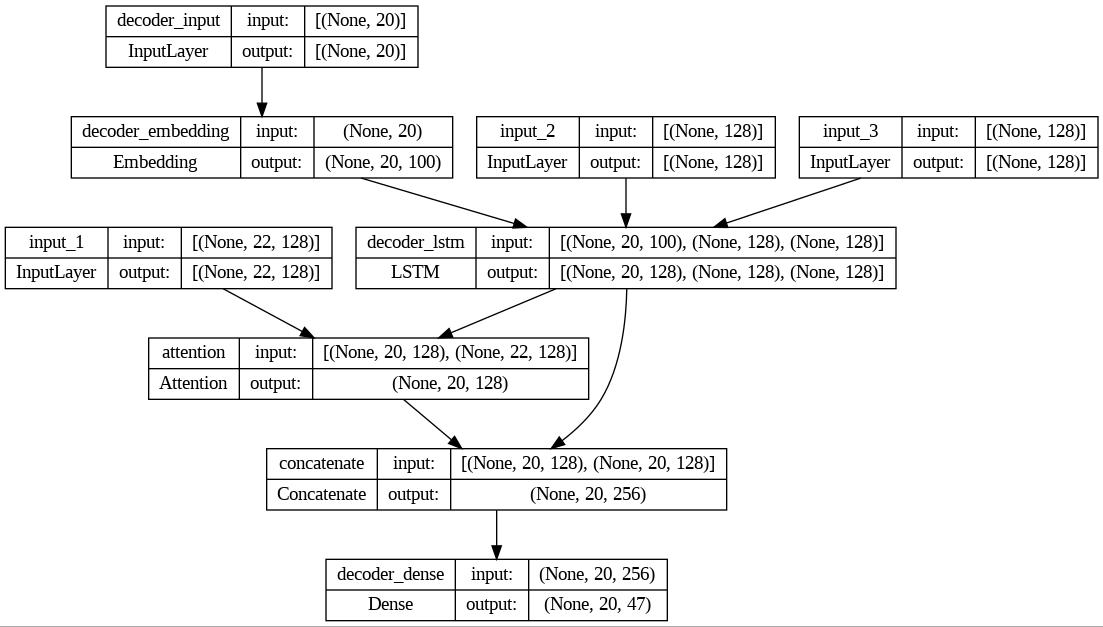

In [ ]:
plot_model(decoder, show_shapes = True, to_file = 'decoder.jpg')

#Prediction

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in eng_tokens.items())
reverse_output_char_index = dict((i, char) for char, i in mm_tokens.items())

In [ ]:
print(reverse_input_char_index)

{1: 'a', 2: 'i', 3: 'n', 4: 'h', 5: 'g', 6: 'k', 7: 'm', 8: 't', 9: 'o', 10: 'u', 11: 'e', 12: 'l', 13: 's', 14: 'p', 15: 'b', 16: 'r', 17: 'd', 18: 'c', 19: 'y', 20: 'w', 21: 'j', 22: 'f', 23: 'v', 24: 'z', 25: 'q', 26: 'x'}


In [ ]:
print(reverse_output_char_index)

{1: '\t', 2: '\n', 3: 'ꯤ', 4: 'ꯥ', 5: 'ꯅ', 6: 'ꯁ', 7: 'ꯕ', 8: 'ꯨ', 9: 'ꯔ', 10: 'ꯣ', 11: 'ꯂ', 12: 'ꯡ', 13: 'ꯗ', 14: 'ꯟ', 15: 'ꯃ', 16: 'ꯄ', 17: 'ꯒ', 18: 'ꯦ', 19: 'ꯝ', 20: 'ꯇ', 21: 'ꯛ', 22: 'ꯀ', 23: 'ꯈ', 24: 'ꯌ', 25: 'ꯊ', 26: 'ꯍ', 27: 'ꯆ', 28: 'ꯩ', 29: 'ꯑ', 30: 'ꯐ', 31: 'ꯠ', 32: 'ꯜ', 33: 'ꯢ', 34: 'ꯧ', 35: 'ꯏ', 36: 'ꯖ', 37: 'ꯋ', 38: '꯭', 39: 'ꯉ', 40: 'ꯎ', 41: 'ꯪ', 42: 'ꯞ', 43: 'ꯚ', 44: 'ꯓ', 45: 'ꯙ', 46: 'ꯘ'}


In [ ]:
def predict_list_of_words(list_source_words_in_padded_int_seq):
  list_pred_words = []
  start_token = np.zeros((1, 1))
  start_token[0] = mm_tokenizer.word_index['\t']
  print(start_token)

  for x in tqdm(range(len(list_source_words_in_padded_int_seq))):
    source_seq = start_token
    pred_word = ''
    v = np.reshape(list_source_words_in_padded_int_seq[x], (1, -1))
    en_out_seq,next_h, next_c = encoder.predict(v,verbose=0)
    for i in range(max_decoder_length):
      output, next_h, next_c = decoder.predict([source_seq] + [en_out_seq,next_h, next_c],verbose=0)
      next_token = np.argmax(output[0, 0, :])
      next_char = reverse_output_char_index[next_token]
      if next_char == '\n':
        break
      else:
        pred_word += next_char
        source_seq = np.zeros((1, 1))
        source_seq[0] = next_token
    list_pred_words.append(pred_word)
  return list_pred_words

#Test

### Test Data Preparation

In [ ]:
test_eng_words = test['english word']
test_mm_words = test['native word']

In [ ]:
for i in range(10):
  print(f"{test_eng_words[i]} - {test_mm_words[i]}")

yallaga - ꯌꯥꯜꯂꯒ
sharuksing - ꯁꯔꯨꯛꯁꯤꯡ
sakpa - ꯁꯛꯄ
asini - ꯑꯁꯤꯅꯤ
jebina - ꯖꯦꯕꯤꯅ
mitana - ꯃꯤꯇꯅ
anput - ꯑꯟꯄꯨꯠ
hiyanggei - ꯍꯤꯌꯥꯡꯒꯩ
thouninarammi - ꯊꯧꯅꯤꯅꯔꯝꯃꯤ
hotnajaramba - ꯍꯣꯠꯅꯖꯔꯝꯕ


### Tokenization

In [ ]:
test_eng_words_in_ids = eng_tokenizer.texts_to_sequences(test_eng_words)
test_mm_words_in_ids = mm_tokenizer.texts_to_sequences(test_mm_words)

In [ ]:
for i in range(10):
  print(f"{test_eng_words_in_ids[i]} ----- {test_mm_words_in_ids[i]}")

[19, 1, 12, 12, 1, 5, 1] ----- [24, 4, 32, 11, 17]
[13, 4, 1, 16, 10, 6, 13, 2, 3, 5] ----- [6, 9, 8, 21, 6, 3, 12]
[13, 1, 6, 14, 1] ----- [6, 21, 16]
[1, 13, 2, 3, 2] ----- [29, 6, 3, 5, 3]
[21, 11, 15, 2, 3, 1] ----- [36, 18, 7, 3, 5]
[7, 2, 8, 1, 3, 1] ----- [15, 3, 20, 5]
[1, 3, 14, 10, 8] ----- [29, 14, 16, 8, 31]
[4, 2, 19, 1, 3, 5, 5, 11, 2] ----- [26, 3, 24, 4, 12, 17, 28]
[8, 4, 9, 10, 3, 2, 3, 1, 16, 1, 7, 7, 2] ----- [25, 34, 5, 3, 5, 9, 19, 15, 3]
[4, 9, 8, 3, 1, 21, 1, 16, 1, 7, 15, 1] ----- [26, 10, 31, 5, 36, 9, 19, 7]


### Padding

In [ ]:
def post_padding(data_in_int_seq, max_seq_len):
  return pad_sequences(data_in_int_seq, max_seq_len, padding = "post")

In [ ]:
test_eng_padded = pad_sequences(test_eng_words_in_ids, maxlen = max_encoder_length, padding = 'post')
test_mm_padded = pad_sequences(test_mm_words_in_ids, maxlen = max_decoder_length, padding = 'post')

In [ ]:
for i in range(10):
  print(f"{test_eng_padded[i]} ----- {test_mm_padded[i]}")

[19  1 12 12  1  5  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] ----- [24  4 32 11 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[13  4  1 16 10  6 13  2  3  5  0  0  0  0  0  0  0  0  0  0  0  0] ----- [ 6  9  8 21  6  3 12  0  0  0  0  0  0  0  0  0  0  0  0  0]
[13  1  6 14  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] ----- [ 6 21 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 1 13  2  3  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] ----- [29  6  3  5  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[21 11 15  2  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] ----- [36 18  7  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[7 2 8 1 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ----- [15  3 20  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 1  3 14 10  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0] ----- [29 14 16  8 31  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 4  2 19  1  3  5  5 11  2  0  0  0  0  0  0  0  0  0  0  0  0  0] --

In [ ]:
predictions = predict_list_of_words(test_eng_padded)
with open('/content/drive/MyDrive/Meitei_Mayek/predictions.txt', 'w') as file:
    for prediction in predictions:
        file.write(prediction + '\n')

[[1.]]


 93%|█████████▎| 4525/4889 [43:22<13:36,  2.24s/it]